<a href="https://colab.research.google.com/github/daljit3/python-colab-notebooks/blob/main/project-notes-azure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install azureml-core
!pip install azureml-dataset-runtime

     |████████████████████████████████| 39.4 MB 1.1 MB/s 
     |████████████████████████████████| 129 kB 68.2 MB/s 
     |████████████████████████████████| 29.3 MB 1.3 MB/s 
     |████████████████████████████████| 1.3 MB 59.4 MB/s 
     |████████████████████████████████| 13.2 MB 29.3 MB/s 


In [ ]:
# azureml-core of version 1.0.72 or higher is required
# azureml-dataprep[pandas] of version 1.1.34 or higher is required
from azureml.core import Workspace, Dataset

subscription_id = '1f036820-df32-4085-b68c-9faa949aea7f'
resource_group = 'galactica'
workspace_name = 'battlestar'

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(workspace, name='titanic')
dataset.to_pandas_dataframe()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,None,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,None,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,None,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [ ]:
data = dataset.to_pandas_dataframe()
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,None,S


In [ ]:
for col in data.columns:
  print(col + ' : ' + str(data[col].value_counts().count()))

PassengerId : 712
Survived : 2
Pclass : 3
Name : 712
Sex : 2
Age : 88
SibSp : 6
Parch : 7
Ticket : 541
Fare : 219
Embarked : 3


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
data = dataset.to_pandas_dataframe()
del data['Cabin']
data = data.dropna()

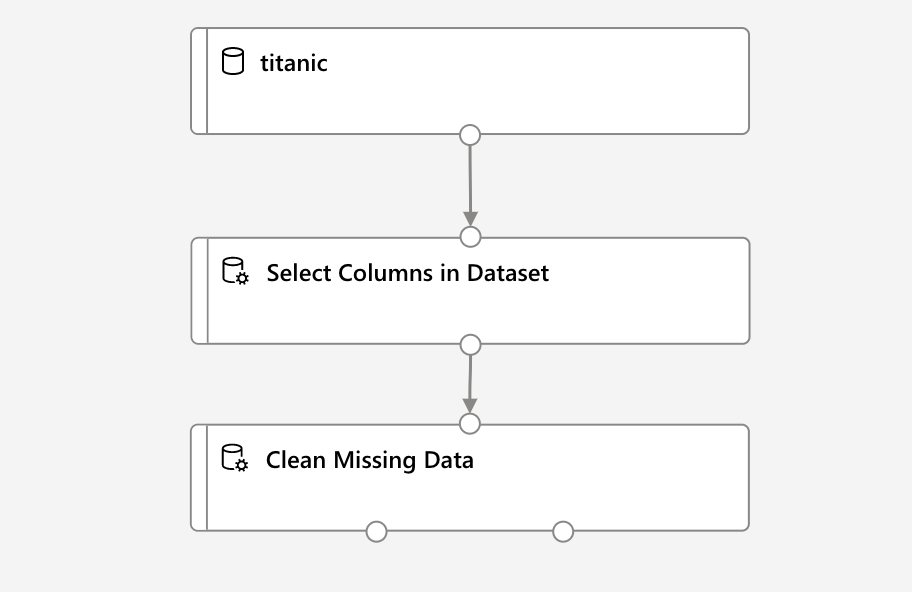

In [ ]:
data.to_csv('cleandata.csv')

In [ ]:
# z-score
y = data.loc[:,'Survived']
x = data.iloc[:,2:]
from sklearn.model_selection import train_test_split
xtrain,xtest, ytrain,ytest = train_test_split(x,y,test_size=0.2)

# calculate training assumptions
stats = xtrain.describe().T
zmean = stats['mean']
zstd = stats['std']

# apply training assumptions in training as well as testing dataset also
normxtrain = (xtrain-zmean)/zstd
normxtest = (xtest-zmean)/zstd



In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          712 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Embarked     712 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 66.8+ KB


In [ ]:
predictions=[1,2,3,4]
ytest = [1.2,2.2,1.5,3.9]

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
modelmse = mean_squared_error(predictions, ytest)
modelmse

0.5850000000000001

In [ ]:
modelmae = mean_absolute_error(predictions, ytest)
modelmae

0.5

In [ ]:
# LAST STEP- DEPLOYMENT-
# Type: Azure Container Instance
import urllib.request
import json
import os
import ssl

def allowSelfSignedHttps(allowed):
    # bypass the server certificate verification on client side
    if allowed and not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None):
        ssl._create_default_https_context = ssl._create_unverified_context

allowSelfSignedHttps(True) # this line is needed if you use self-signed certificate in your scoring service.

# Request data goes here
data = {
    "Inputs": {
        "WebServiceInput0":
        [
            {
                'PassengerId': "1",
                'Survived': "0",
                'Pclass': "3",
                'Name': "Braund, Mr. Owen Harris",
                'Sex': "male",
                'Age': "22",
                'SibSp': "1",
                'Parch': "0",
                'Ticket': "A/5 21171",
                'Fare': "7.25",
                'Cabin': "",
                'Embarked': "S",
            },
        ],
    },
    "GlobalParameters": {
    }
}

body = str.encode(json.dumps(data))

url = 'http://f407b46b-0a43-4fac-aa09-36847b04ad1f.eastus2.azurecontainer.io/score'
api_key = 'p5GmbNSPKDST8w03hnhqxDRZisbMuFje' # Replace this with the API key for the web service
headers = {'Content-Type':'application/json', 'Authorization':('Bearer '+ api_key)}

req = urllib.request.Request(url, body, headers)

try:
    response = urllib.request.urlopen(req)

    result = response.read()
    print(result)
except urllib.error.HTTPError as error:
    print("The request failed with status code: " + str(error.code))

    # Print the headers - they include the requert ID and the timestamp, which are useful for debugging the failure
    print(error.info())
    print(json.loads(error.read().decode("utf8", 'ignore')))

b'{"Results": {"WebServiceOutput0": [{"PassengerId": 1, "Survived": 0, "Pclass": 3, "Name": "Braund, Mr. Owen Harris", "Sex": "male", "Age": -0.527668557291984, "SibSp": 0.5225107881133605, "Parch": 0, "Ticket": "A/5 21171", "Fare": -0.5163799235734484, "Embarked": "S", "Scored Probabilities_0": 0.8376550326344652, "Scored Probabilities_1": 0.16234496736553483, "Scored Labels": 0}]}}'


In [ ]:
# FROM OUR PYTHON PROGRAM YESTERDAY!
import urllib.request
import json
import os
import ssl

def allowSelfSignedHttps(allowed):
    # bypass the server certificate verification on client side
    if allowed and not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None):
        ssl._create_default_https_context = ssl._create_unverified_context

allowSelfSignedHttps(True) # this line is needed if you use self-signed certificate in your scoring service.

# Request data goes here
data = {
}

body = str.encode(json.dumps(data))

url = 'http://5ee6e107-61cc-4ea1-a4a5-067e059f829a.eastus2.azurecontainer.io/score'
api_key = '' # Replace this with the API key for the web service
headers = {'Content-Type':'application/json', 'Authorization':('Bearer '+ api_key)}

req = urllib.request.Request(url, body, headers)

try:
    response = urllib.request.urlopen(req)

    result = response.read()
    print(result)
except urllib.error.HTTPError as error:
    print("The request failed with status code: " + str(error.code))

    # Print the headers - they include the requert ID and the timestamp, which are useful for debugging the failure
    print(error.info())
    print(json.loads(error.read().decode("utf8", 'ignore')))